# Tutorial on Deep Learning 
Pratical Session

##Fraud Detection

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

plt.style.use('ggplot')
import seaborn as sns
print(tf.__version__)

2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
csv_path = tf.keras.utils.get_file(
    origin='https://drive.google.com/uc?authuser=0&id=1-E1myWwpFB0Z47vGDUMCtpURHr-4PZWp&export=download',
    fname='creditcard.zip', extract=True)

66363392/Unknown - 12s 0us/step

In [0]:
df = pd.read_csv(csv_path, index_col="Time")

In [7]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Activity')]

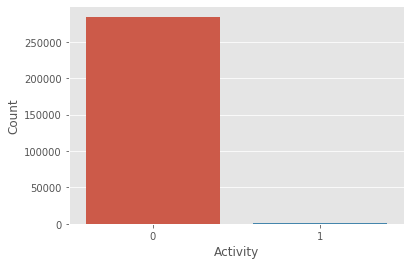

In [0]:
ax = sns.countplot(x="Class", data=df)
ax.set(xlabel='Activity', ylabel='Count')

In [0]:
print("Class Distribution    ", "Fraud: ",(df.Class==1).sum()/df.shape[0]*100, "Not Fraud: ",(df.Class==0).sum()/df.shape[0]*100)

Class Distribution     Fraud:  0.1727485630620034 Not Fraud:  99.82725143693798


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1], test_size=0.2)

Time
73377.0     0
133558.0    0
47108.0     0
140438.0    0
73822.0     0
           ..
77367.0     0
75301.0     0
146217.0    0
142719.0    0
62326.0     0
Name: Class, Length: 227845, dtype: int64

In [0]:
from sklearn.preprocessing import RobustScaler

scale_columns = df.columns[0:-2]
scaler = RobustScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train.to_numpy())
x_test = scaler.transform(x_test.to_numpy())

In [0]:
INPUT_DIM = x_train.shape[1]
CODE_DIM = 14

model = tf.keras.Sequential([
    tf.keras.layers.Dense(CODE_DIM, batch_input_shape=(None, INPUT_DIM), activation="tanh", activity_regularizer=tf.keras.regularizers.l1(10e-5)),
    tf.keras.layers.Dense(INPUT_DIM, activation='relu')
])
model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 29)                435       
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________


In [0]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [0]:
history = model.fit(
    x_train, x_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    shuffle=True
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/20
227845/227845 [==============================] - 15s 65us/sample - loss: 1.4415 - accuracy: 0.6195 - val_loss: 1.2608 - val_accuracy: 0.6786
Epoch 2/20
227845/227845 [==============================] - 14s 63us/sample - loss: 1.2319 - accuracy: 0.6884 - val_loss: 1.1769 - val_accuracy: 0.6905
Epoch 3/20
227845/227845 [==============================] - 14s 63us/sample - loss: 1.1753 - accuracy: 0.6930 - val_loss: 1.1419 - val_accuracy: 0.6950
Epoch 4/20
227845/227845 [==============================] - 15s 65us/sample - loss: 1.1485 - accuracy: 0.6944 - val_loss: 1.1268 - val_accuracy: 0.6893
Epoch 5/20
227845/227845 [==============================] - 14s 62us/sample - loss: 1.1324 - accuracy: 0.6939 - val_loss: 1.1099 - val_accuracy: 0.7005
Epoch 6/20
227845/227845 [==============================] - 14s 63us/sample - loss: 1.1228 - accuracy: 0.6946 - val_loss: 1.1022 - val_accuracy: 0.6979
Epoch 7/20
227845/227845 [===========

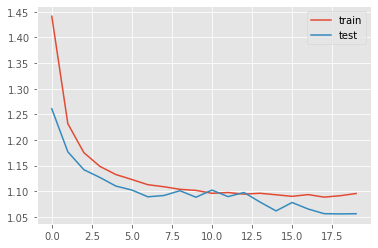

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
predictions = model.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

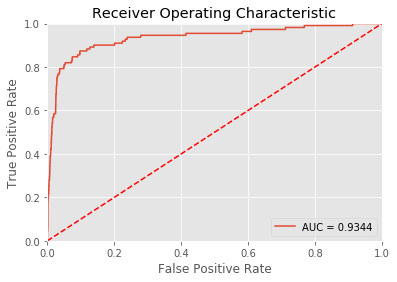

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

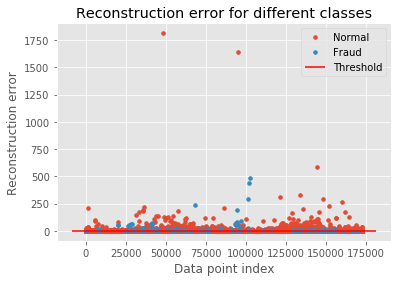

In [0]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print(conf_matrix)

[[54681  2170]
 [   23    88]]


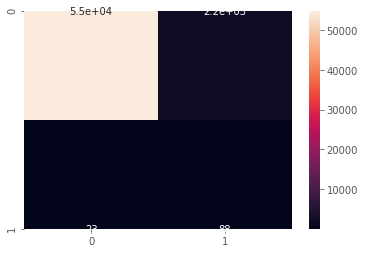

In [0]:
sns.heatmap(conf_matrix, annot=True)